# Function 2 - Log-likelihood

### First Inspection

We are told that the black-box function returns a log-likelihood score and is noisy with mulitple local minima. From the scatterplot, it is apparent that the function is indeed likely to be multimodal,

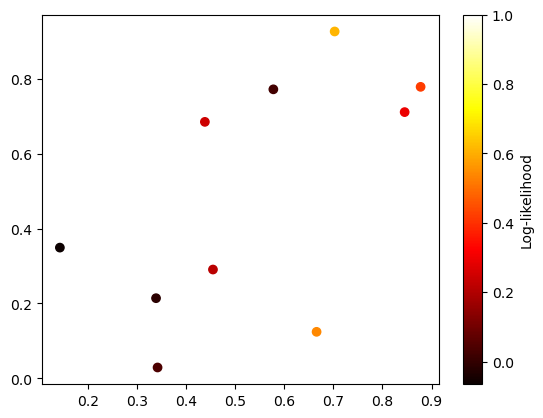

In [10]:
# Depedencies,
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# SKOPT imports,
from skopt import gp_minimize
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from skopt import Optimizer
from joblib import dump, load

# Loading know evaluations,
X, y = np.load("initial_inputs.npy"), np.load("initial_outputs.npy")

# Plotting,
plt.scatter(X.T[0], X.T[1], c=y, cmap="hot", vmax=1)
plt.plot()
plt.colorbar(label="Log-likelihood")
plt.show()

Since the data points are sparse and we are told that the black-box function is multimodal, we cannot restict the optimisation domain. We can make an educated guess that the domain of the black-box function is $[0, 1]^2$.

### Optimiser Configuration

From the discription of the black-box function, we know that,

- The black-box $f(x)$ function is noisy.
- $f(x)$ has many local minima. 
- Ignoring noisy, log-likehood functions tend to be smooth and well-behaved.

Since our black-box function is noisy, our choosen kernel must be able to account for this. Furthermore, given that we are told our log-likehood function has multiple peaks, we cannot expect smoothness throughout our entire domain. Instead of selecting our default, RBF with ARD, we opt for the Matérn 5/2 kernel (with ARD) which has been cited as more practical when it comes to black-box funcions which have variablility in their smoothness (Snoek et al., 2012). For our 2D function where $\mathbf{x}_i = [x_{i1}, x_{i2}]$, each element $K_{ij}$ of general Matérn kernel is (Sci-kit Learn, 2025),

$$
K(\mathbf{x}_i, \mathbf{x}_j)
=
\sigma^2
\frac{2^{1-\nu}}{\Gamma(\nu)}
\left(
\sqrt{2\nu}\, r_{ij}
\right)^{\nu}
K_{\nu}
\left(
\sqrt{2\nu}\, r_{ij}
\right),
$$

$$
r_{ij}
=
\sqrt{
\frac{(x_{i1} - x_{j1})^2}{\ell_1^2}
+
\frac{(x_{i2} - x_{j2})^2}{\ell_2^2}
}.
$$

In our case, we have $\mu = 5/2$ (twice differentiable function). Note that $K_{\nu}$ is the modified Bessel function and $\Gamma_{\nu}$ is the gamma function. We use this kernel with an additional white-noise kernel $\mathbf{K} to account for the noise 

[EQUATION]

Our best choice of aquisition function is the LCB because we want to balance between exploration and exploitation.

### Optimiser Initialisation



In [4]:
"""INITALISING THE OPTIMISATION MODEL."""

# Inputting the given evaluations provided by the problem,
X_supplied = X.tolist()
y_supplied = y.tolist()

"""OPTIMISER SETTINGS."""

# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(0, 1, name="x1"),
         Real(0, 1, name="x2")
         ]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * Matern(
    length_scale=(0.1, 0.1),
    length_scale_bounds=(1e-2, 1.0),
    nu = 5/2) + WhiteKernel(noise_level=1.0)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10
)

# Creating optimisier,
opt = Optimizer(
    dimensions=space,
    base_estimator=gpr,
    acq_func="LCB",
    acq_func_kwargs={"kappa": 2.0},
    random_state=0
)

"""CREATING INTIAL OPTIMISER STATE."""

# Supplying given points to optimiser,
opt.tell(X_supplied, (-np.array(y_supplied)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state (zero-th iteration),
dump(opt, "bayes_opt_state_iter0.joblib")

# Printing point query,
print(f"Point Query: {point_query}")

Point Query: [0.7140222471762984, 0.14477214123066873]


### Next Query

In [12]:
current_query = 1

# Input the new evaluation,
X_new = [[0.714022, 0.144772]]
y_new = [0.5974724463060992]

# Loading the previous state of the optimiser,
opt = load(f"bayes_opt_state_iter{current_query - 1}.joblib")

# Supplying the new query to the optimiser,
opt.tell(X_new, (-np.array(y_new)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state,
dump(opt, f"bayes_opt_state_iter{current_query}.joblib")

# Printing point query,
print(f"Point Query {current_query + 1}: {point_query}")

Point Query 2: [0.7427519875760962, 0.883974791661517]


### Visualising Progress

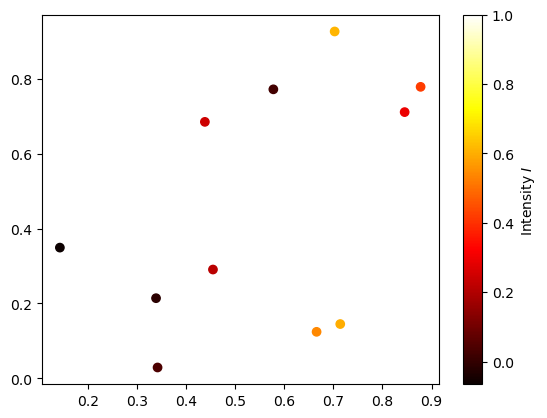

In [11]:
# Loading know evaluations,
X, y = np.load("initial_inputs.npy"), np.load("initial_outputs.npy")

# New evaluations,
X_new = [[0.714022, 0.144772]]
y_new = [0.5974724463060992]

# Concatenating,
X = np.concatenate((X, X_new), axis=0)
y = np.concatenate((y, y_new), axis=0)

# Plotting,
plt.scatter(X.T[0], X.T[1], c=y, cmap="hot", vmax=1)
plt.plot()
plt.colorbar(label="Intensity $I$")
plt.show()

In [7]:
y

array([ 0.53899612,  0.42058624, -0.06562362,  0.29399291,  0.21496451,
        0.02310555,  0.24461934,  0.03874902, -0.01385762,  0.61120522,
        0.59747245])